# Visualising seismic traces
 Loops through data folders and plot lines with start and end points

In [1]:
# Import necessary packages
import segyio
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
folder_dir = "/Users/ming.../Desktop/Lab/Okavango/OK19_Dataprocessed" # Folder which includes all samples
file_names = os.listdir(folder_dir) # Sample names
num_files = len(file_names) # Count number of seismic traces


In [3]:
print(file_names)

['Line0030_processed.sgy', 'Line0033_processed.sgy', 'Line0032_processed.sgy', 'Line0031_processed.sgy']


In [4]:
# Set up empty array to store all coords
sx_all = np.array([])
sy_all = np.array([])
sx_start_all = np.array([])
sx_end_all = np.array([])
sy_start_all = np.array([])
sy_end_all = np.array([])
line_num_all = []
tracelines = {}

# Loop through folder
for i in range (num_files):
    with segyio.open(folder_dir + "/" + file_names[i], "r", ignore_geometry=True) as f:
        # Store source coordinates as an array
        sx = np.array([f.header[j][segyio.TraceField.SourceX] for j in range(f.tracecount)])
        sy = np.array([f.header[j][segyio.TraceField.SourceY] for j in range(f.tracecount)])
        dt = f.bin[segyio.BinField.Interval] / 1000  # collecting sample interval in ms
        # Take start and end coords of end trace line
        sx_start = sx[0]
        sx_end = sx[-1]
        sy_start = sy[0]
        sy_end = sy[-1]
        line_num = file_names[i].strip("Lineprocessed.sgy_")

        # Add them to sx_all and sy_all respectively
        sx_all = np.append(sx_all, sx)
        sy_all = np.append(sy_all, sy)
        sx_start_all = np.append(sx_start_all, sx_start)
        sx_end_all = np.append(sx_end_all, sx_end)
        sy_start_all = np.append(sy_start_all, sy_start)
        sy_end_all = np.append(sy_end_all, sy_end)
        line_num_all.append(line_num)

        # Store trace data
        data = np.zeros((f.tracecount, f.samples.size), dtype=np.float32) # Creates a canvas of zeros with the shape of (number of traces, number of samples)
        # fill the array with trace data
        for l in range(f.tracecount):
            data[l, :] = f.trace[l]
        tracelines[line_num] = data
        print(f.bin[segyio.BinField.Interval])
        

        

100
100
100
100


## Plotting
All source coordinates plotted in black, start point in blue and end point in red. Add line label.

Text(0, 0.5, 'Y coords (UTM)')

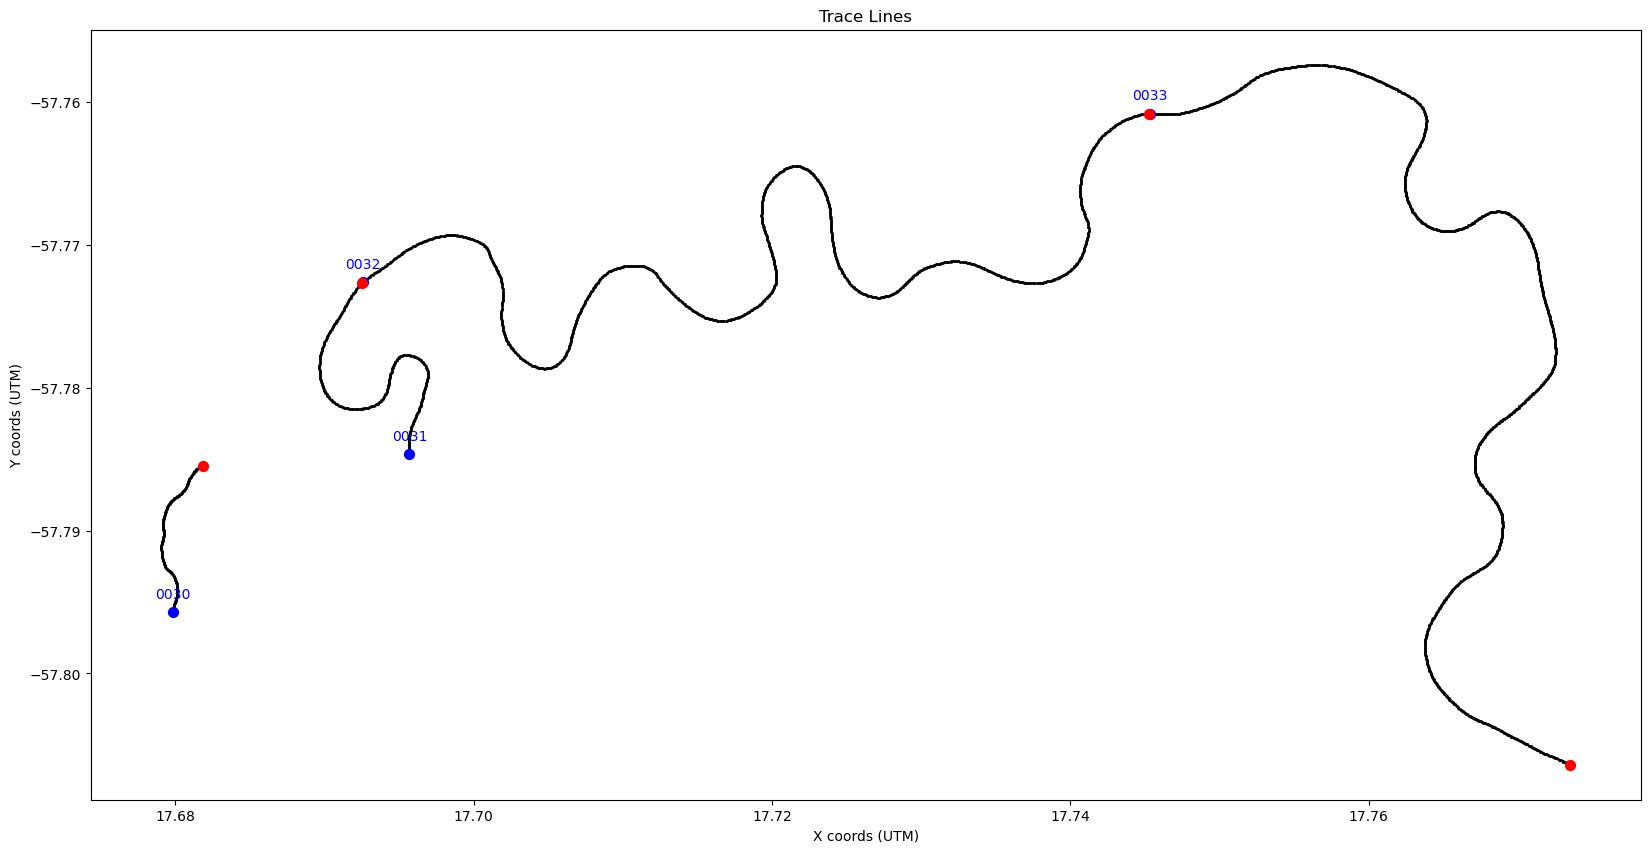

In [5]:
# Set up figure
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(sx_all/36000, sy_all/36000, s = 1, color="black", alpha=0.6)
ax.scatter(sx_start_all/36000, sy_start_all/36000, s=50, color="blue", alpha=1)
ax.scatter(sx_end_all/36000, sy_end_all/36000, s=50, color="red", alpha=1)
for k, txt in enumerate(line_num_all):
    plt.annotate(txt, (sx_start_all[k]/36000, sy_start_all[k]/36000), textcoords="offset points", xytext=(0,10), ha='center', color="blue")
ax.set_title("Trace Lines")
ax.set_xlabel("X coords (UTM)")
ax.set_ylabel("Y coords (UTM)")

# Plot with map
Visualize with a map

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

Text(0, 0.5, 'Y coords (UTM)')

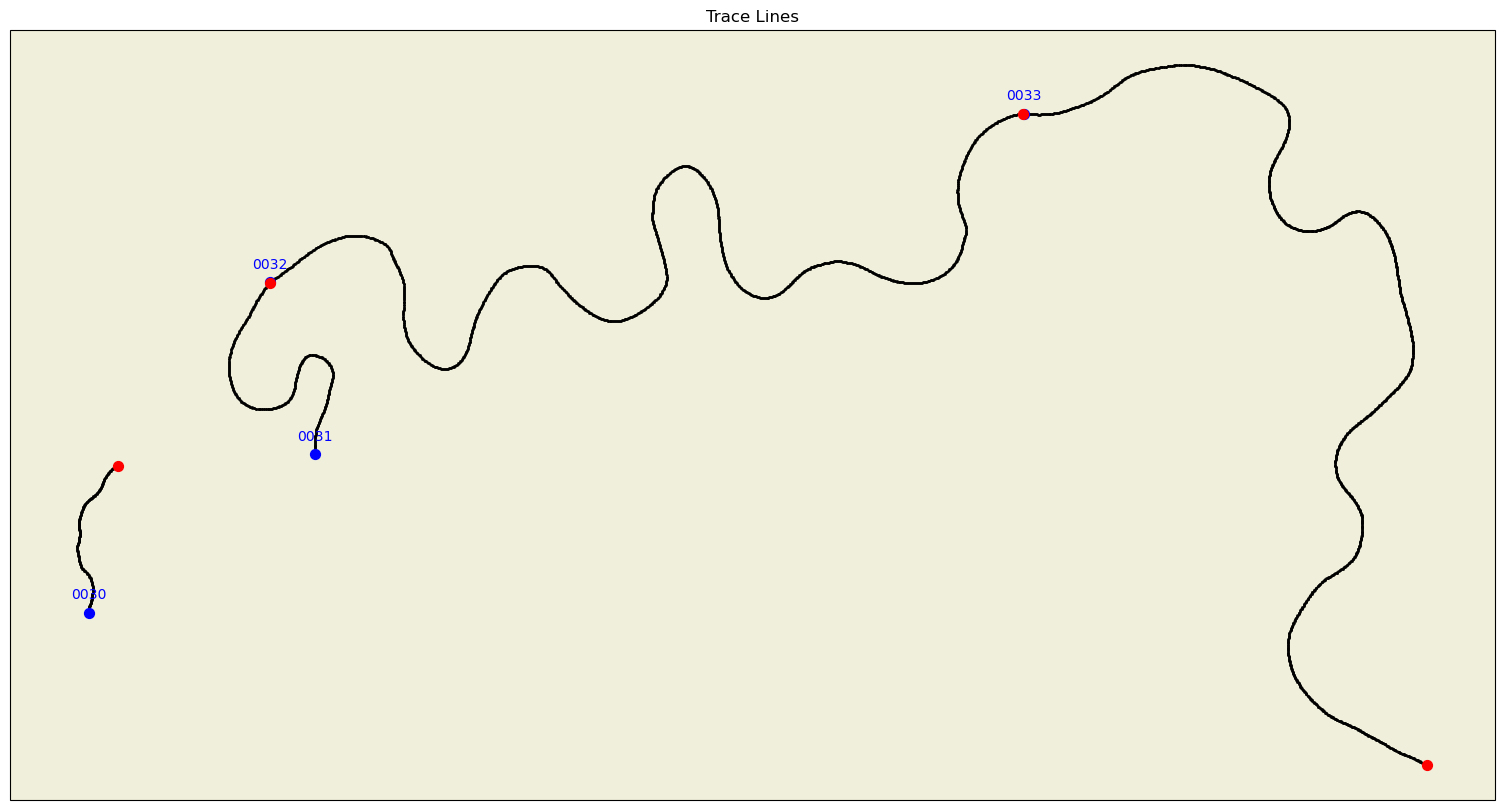

In [7]:
# Set up figure
fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': ccrs.UTM(zone=34)})

# Add data
ax.scatter(sx_all, sy_all, s = 1, color="black", alpha=0.6)
ax.scatter(sx_start_all, sy_start_all, s=50, color="blue", alpha=1)
ax.scatter(sx_end_all, sy_end_all, s=50, color="red", alpha=1)
# Add trace line numbers
for k, txt in enumerate(line_num_all):
    plt.annotate(txt, (sx_start_all[k], sy_start_all[k]), textcoords="offset points", xytext=(0,10), ha='center', color="blue", transform=ccrs.UTM(zone=34))

# Add map details
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)

# Add labels
ax.set_title("Trace Lines")
ax.set_xlabel("X coords (UTM)")
ax.set_ylabel("Y coords (UTM)")

## Plot seismic traces

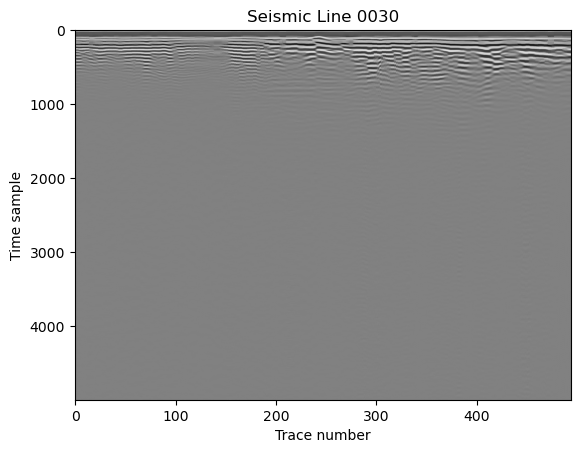

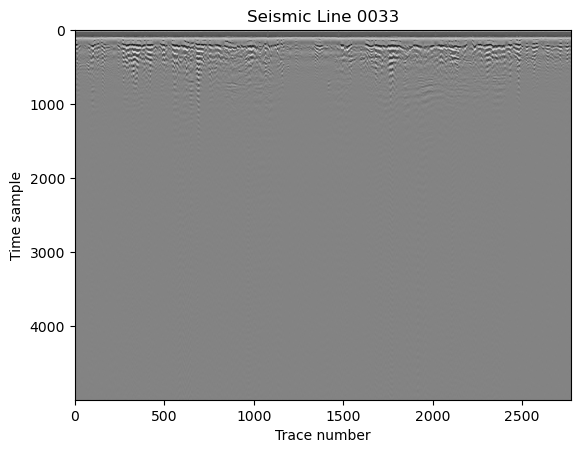

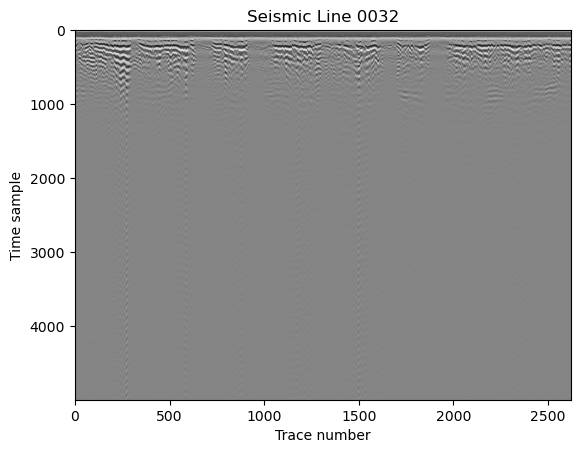

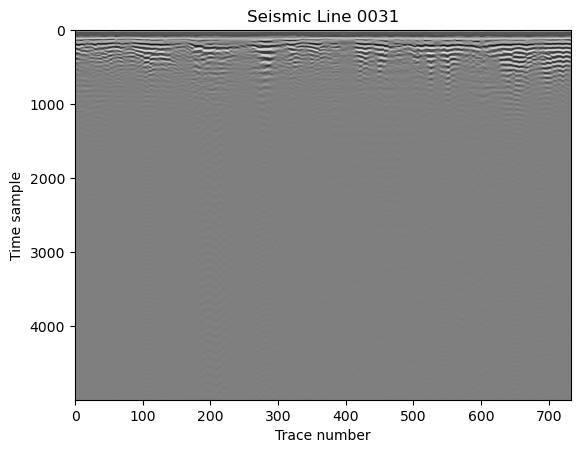

In [8]:
# Loop and plot
for m in range (num_files):
    plt.imshow(tracelines[line_num_all[m]].T, cmap="gray", aspect="auto") # Transpose to have traces on x-axis in data.T
    plt.title("Seismic Line "+ line_num_all[m])
    plt.xlabel("Trace number")
    plt.ylabel("Time sample")
    plt.show()

## Frequency spectra (FFT)

In [9]:
def fspectra(data, dt = 100):
    """
    Calculcate the frequency spectra
    """
    # Amplitude values
    # Get absolute values of fourier coefficients
    fc = np.abs(np.fft.rfft(data, axis=-1))

    # Take mean to get the amplitude values of the spectra
    a = np.mean(fc, axis=0)

    # Get the frequency values corresponding to the cofficients
    # We need the length of the window and the sample interval in seconds

    dts = dt/1000
    length = data.shape[-1]

    f = np.fft.rfftfreq(length, d = dts)

    return f, a

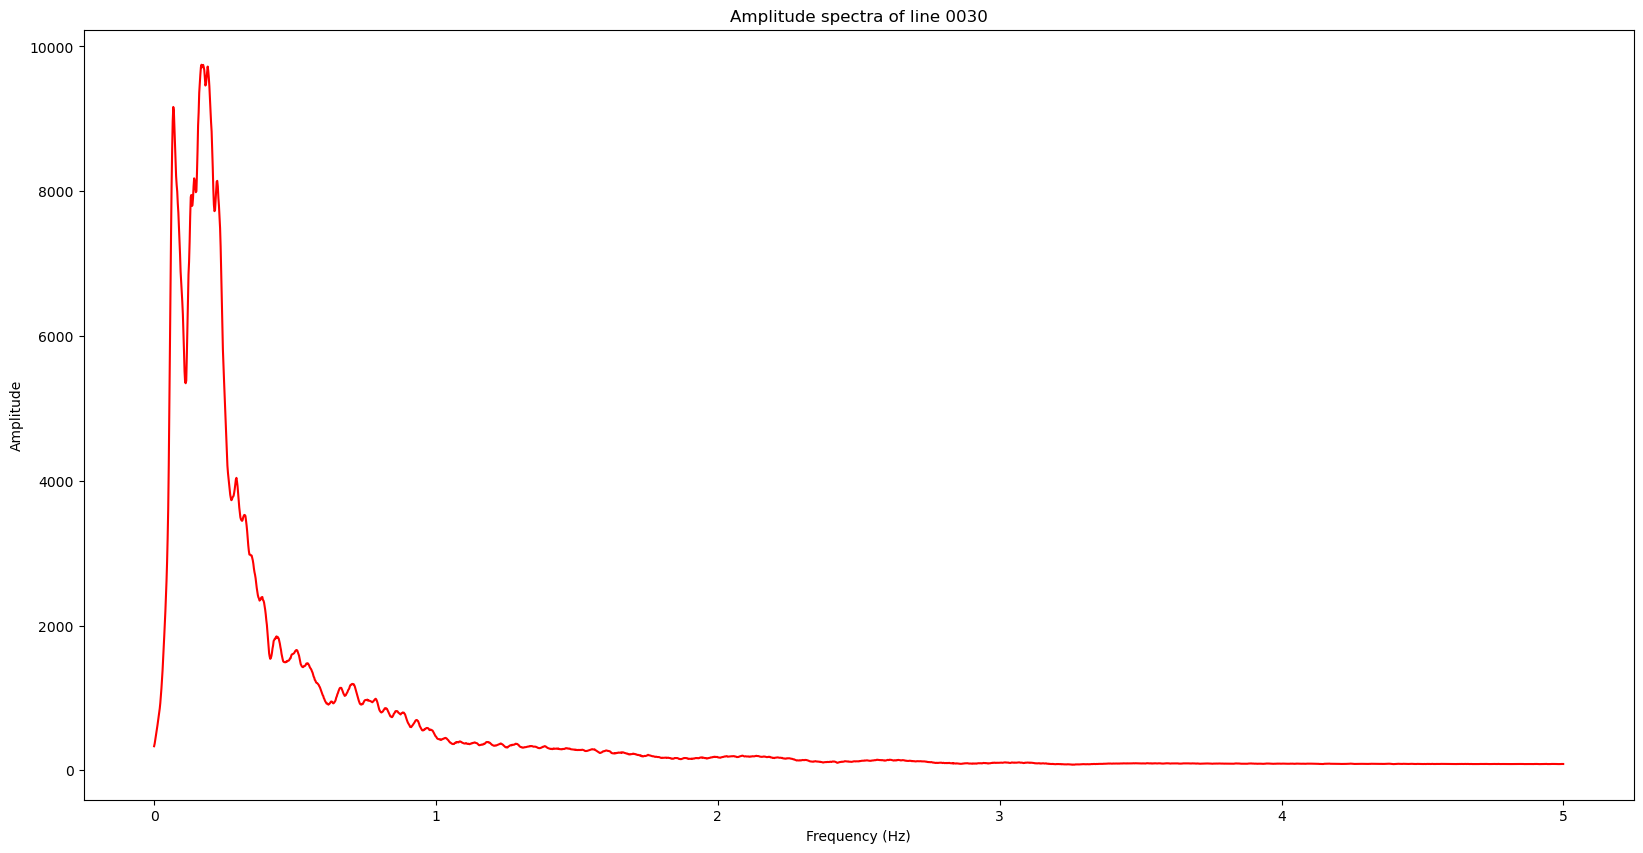

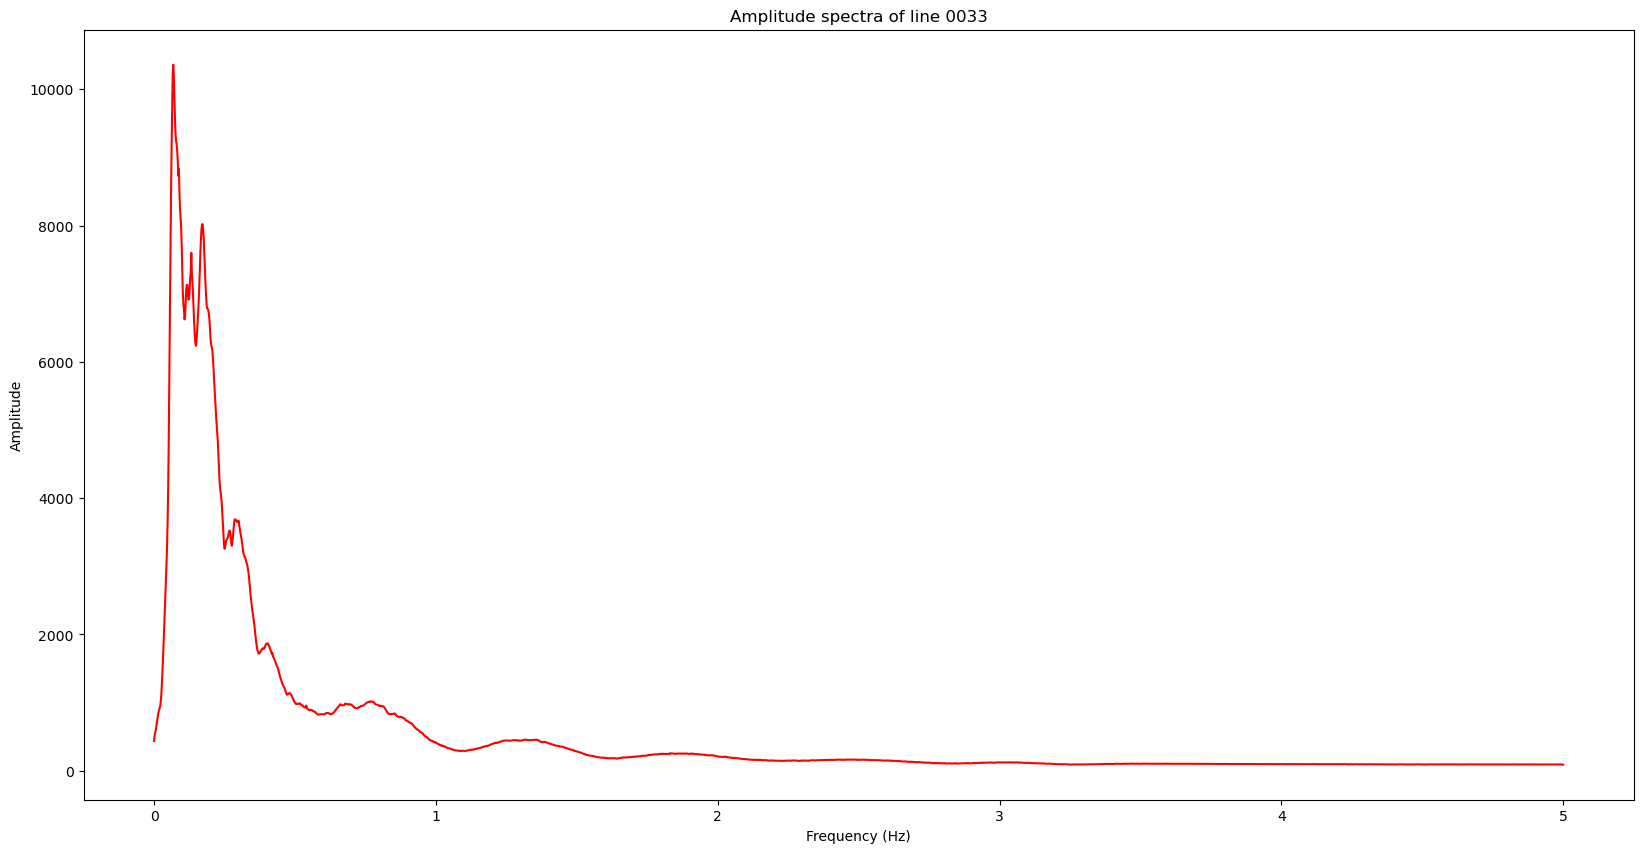

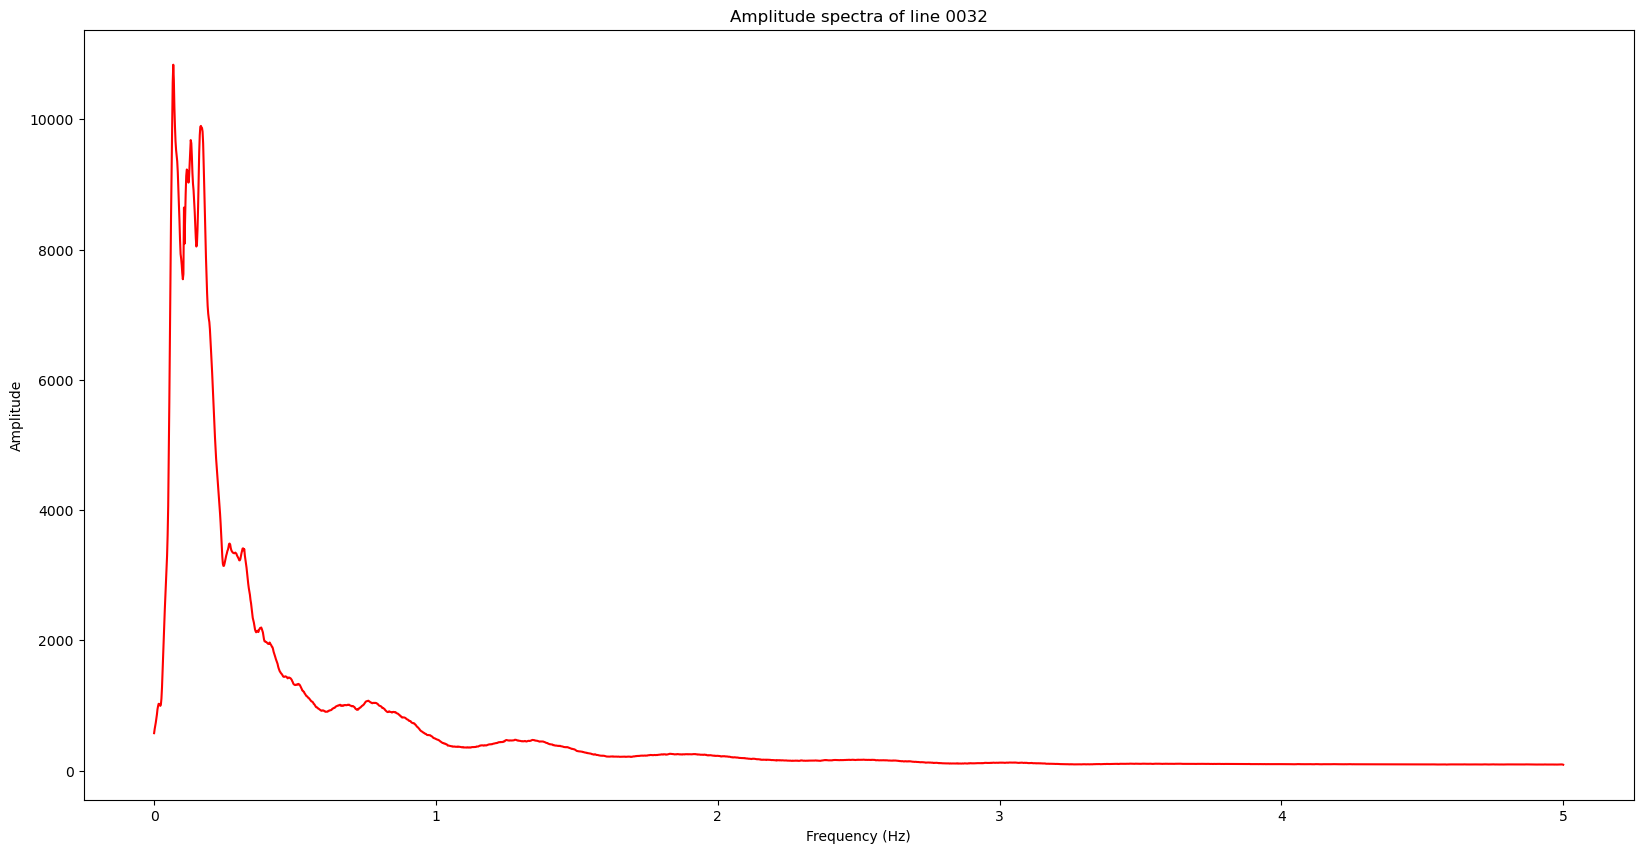

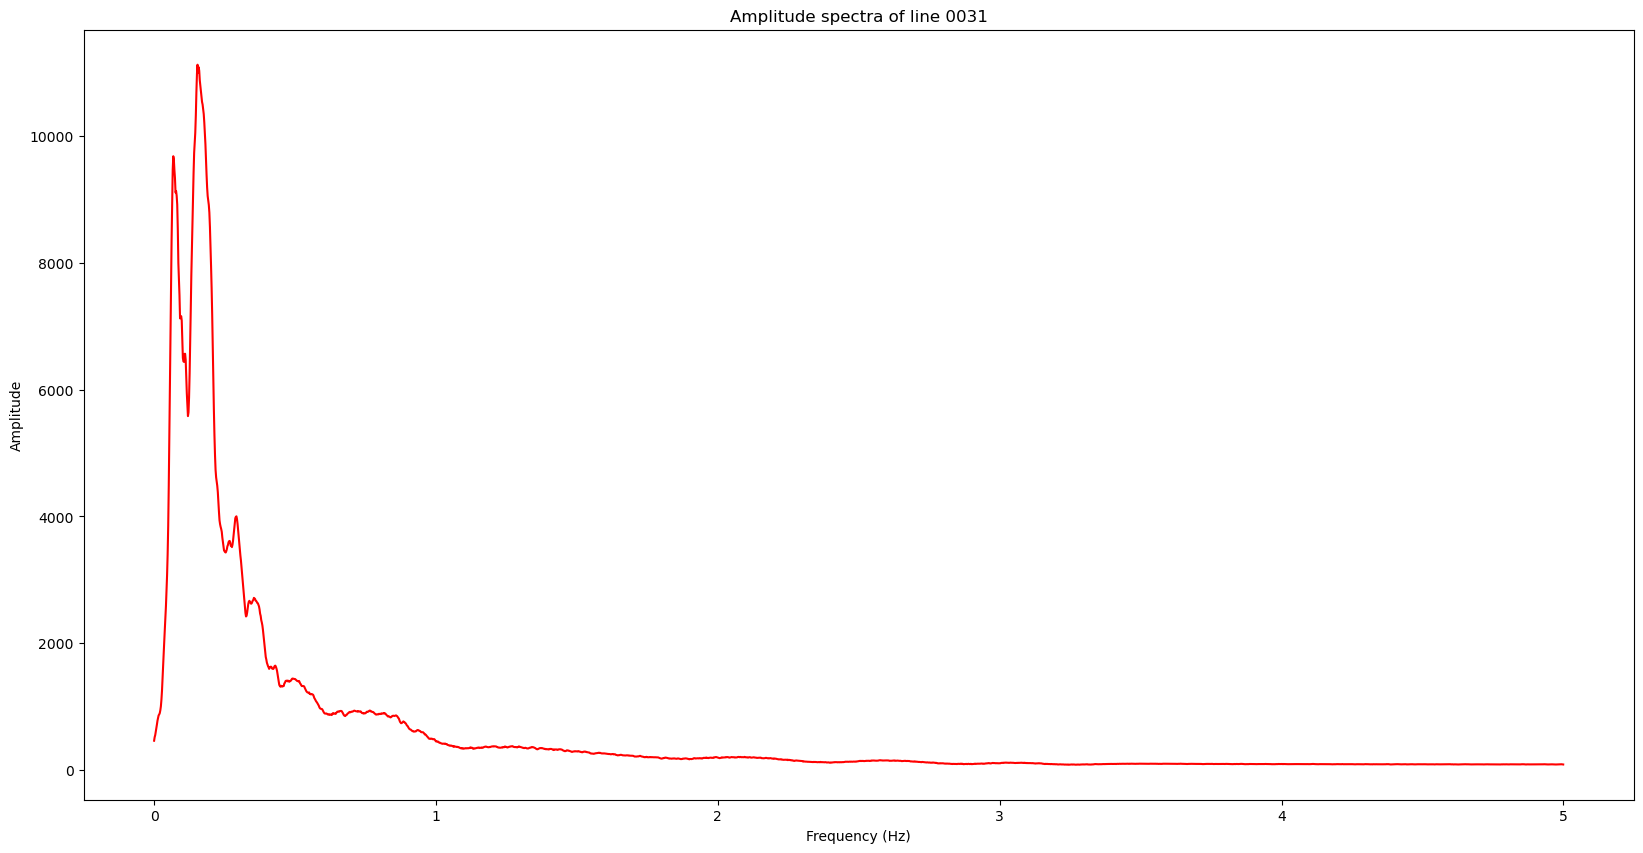

In [10]:
for i in range (num_files):
    freq, amp = fspectra(tracelines[line_num_all[i]])

    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(freq, amp, color="r")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel(("Amplitude"))
    ax.set_title("Amplitude spectra of line "+line_num_all[i])

In [11]:
max(freq)

np.float64(4.998999799959992)

## Automatic Gain Control

In [12]:
from scipy.signal import convolve

def seismic_agc_traces(traces, window_length_samples, mode="rms"):
    """
    Applies Automatic Gain Control (AGC) to multiple seismic traces.

    Args:
        traces (np.ndarray): 2D array of seismic traces (n_traces x n_samples).
        window_length_samples (int): Length of the sliding window in samples.
        mode (str): Amplitude measure, "rms" (default) or "mean_abs".

    Returns:
        np.ndarray: AGC-applied traces, same shape as input.
    """
    if not isinstance(traces, np.ndarray) or traces.ndim != 2:
        raise ValueError("Input 'traces' must be a 2D NumPy array (n_traces x n_samples).")
    if not isinstance(window_length_samples, int) or window_length_samples <= 0:
        raise ValueError("Input 'window_length_samples' must be a positive integer.")
    if mode not in ("rms", "mean_abs"):
        raise ValueError("mode must be 'rms' or 'mean_abs'")

    n_traces, n_samples = traces.shape
    agc_traces = np.zeros_like(traces, dtype=float)

    # Define window for convolution (normalized moving average)
    window = np.ones(window_length_samples) / window_length_samples

    for i in range(n_traces):
        trace = traces[i]

        if mode == "rms":
            # Compute RMS envelope with convolution
            mean_sq = convolve(trace**2, window, mode="same")
            amplitude = np.sqrt(mean_sq)
        elif mode == "mean_abs":
            # Compute mean absolute envelope
            mean_abs = convolve(np.abs(trace), window, mode="same")
            amplitude = mean_abs

        # Avoid division by zero
        amplitude[amplitude < 1e-9] = 1.0

        # Apply AGC
        agc_traces[i] = trace / amplitude

    return agc_traces


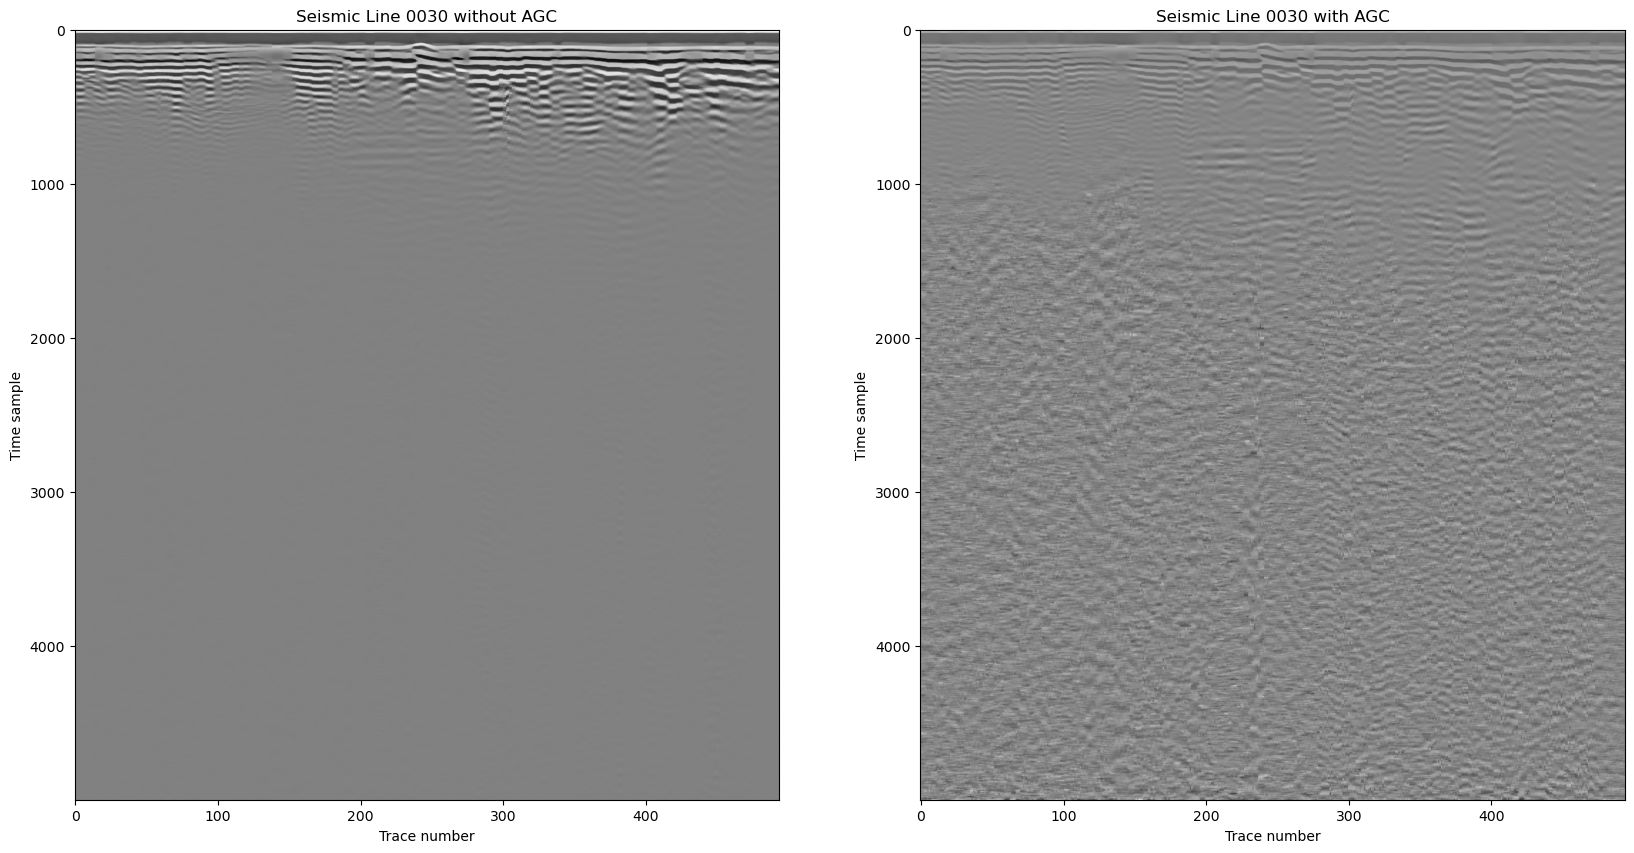

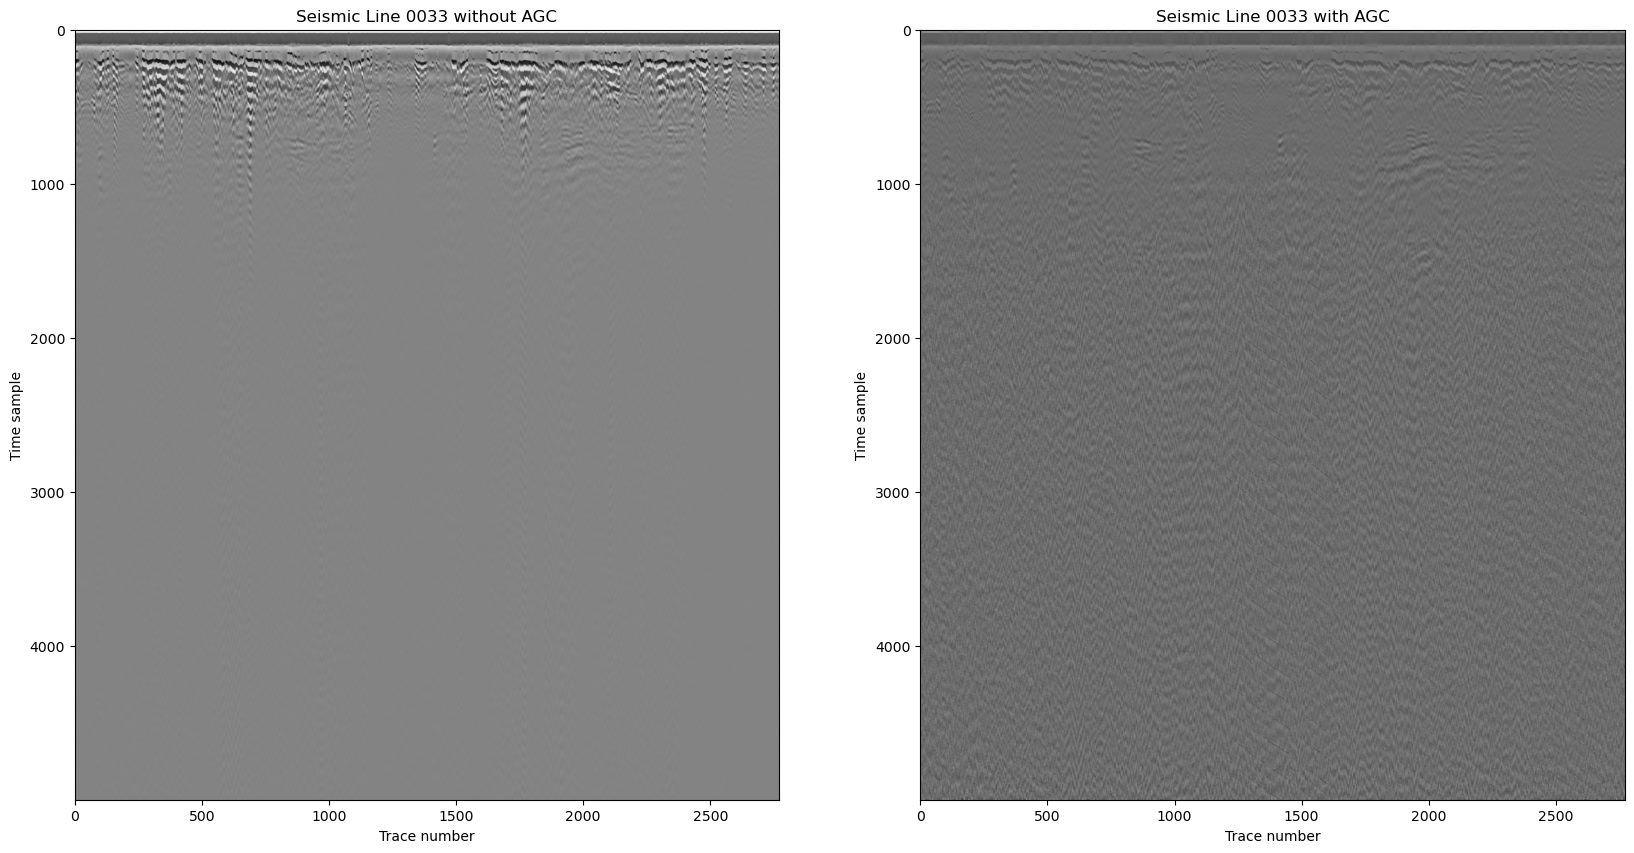

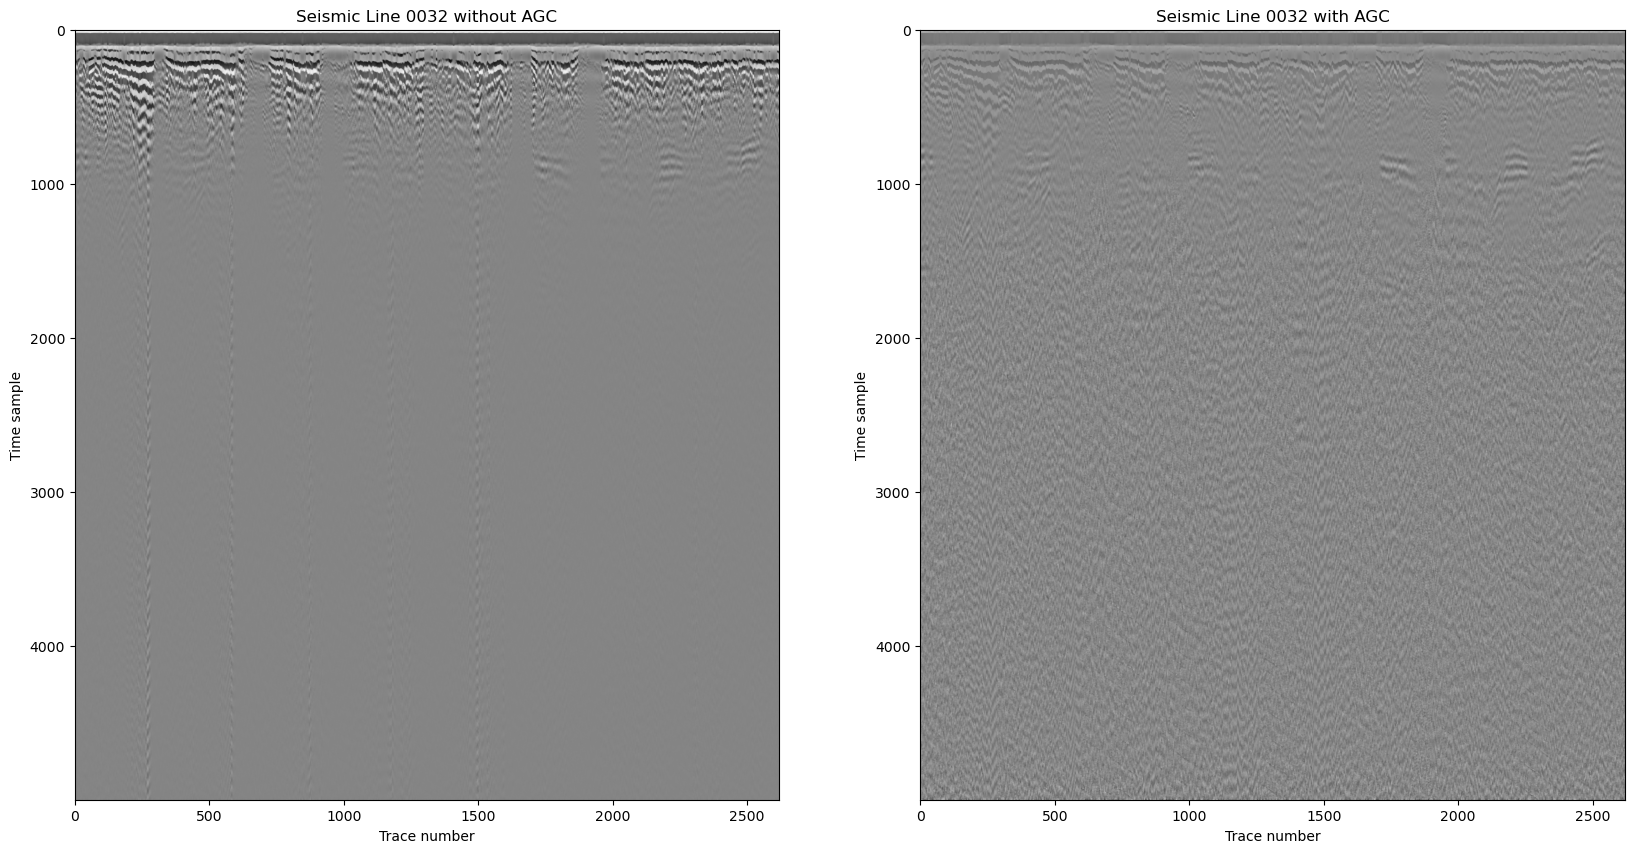

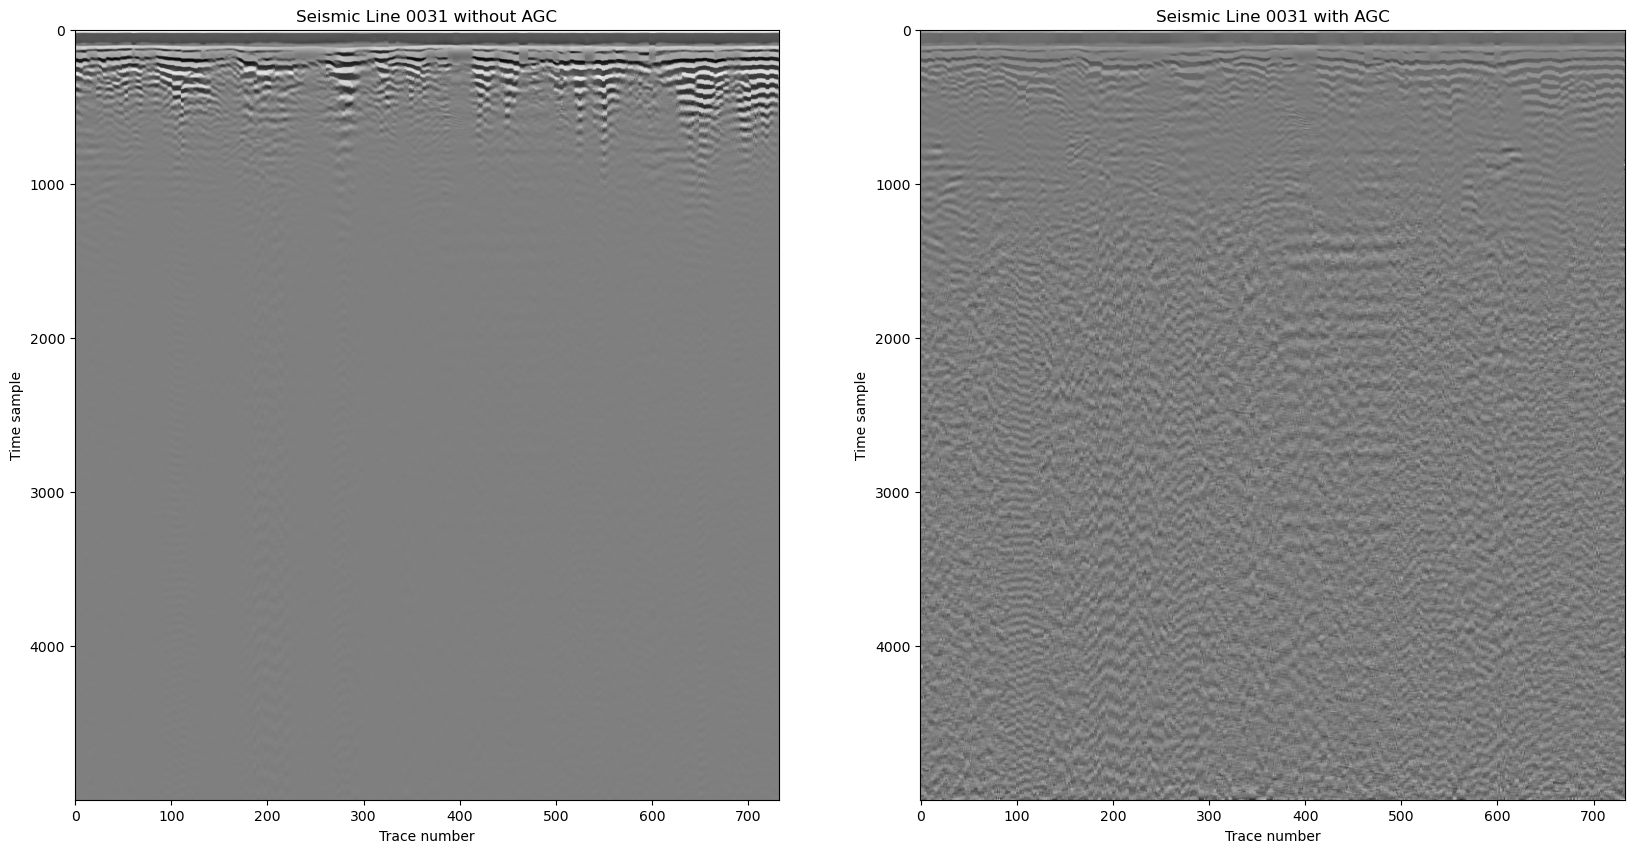

In [51]:
for i in range (num_files):
    agc_trace = seismic_agc_traces(tracelines[line_num_all[i]], 800)

    fig, ax = plt.subplots(1, 2, figsize=(20,10))

    im0 = ax[0].imshow(tracelines[line_num_all[i]].T, cmap="gray", aspect="auto")
    ax[0].set_title("Seismic Line " + line_num_all[i] + " without AGC")
    ax[0].set_xlabel("Trace number")
    ax[0].set_ylabel("Time sample")

    im0 = ax[1].imshow(agc_trace.T, cmap="gray", aspect="auto")
    ax[1].set_title("Seismic Line " + line_num_all[i] + " with AGC")
    ax[1].set_xlabel("Trace number")
    ax[1].set_ylabel("Time sample")